### 딥-러닝 과정 Mulit Layer Perceptron(MLP) 

## Keras 모델 생성/학습 - 당뇨병 예측 모델

In [1]:
# 1. Pandas 가져오기
import pandas as pd
import numpy as np

In [2]:
# 2. 데이터 불러오기
data = pd.read_csv('diabetes_data.csv')

In [3]:
data.head()

,pregnant,gloucose,blood pressure,skin thickness,insulin,BMI,DPF,age,result
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pregnant        768 non-null    int64  
 1   gloucose        768 non-null    int64  
 2   blood pressure  768 non-null    int64  
 3   skin thickness  768 non-null    int64  
 4   insulin         768 non-null    int64  
 5   BMI             768 non-null    float64
 6   DPF             768 non-null    float64
 7   age             768 non-null    int64  
 8   result          768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# 3. X/y 나누기
X = data.copy().drop(['result'], axis = 1)
y = data.copy()['result']

In [6]:
# 4. Train set, Test set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)

print('X:', X_train.shape, X_test.shape)
print('y:', y_train.shape, y_test.shape)

X: (614, 8) (154, 8)
y: (614,) (154,)


## 전처리 후 모델링 해보기
# EDA


* pregnant : 임신횟수
* glucose : 포도당 부하 검사 수치
* bloodpressure : 혈압
* Skinthickness : 팔 삼두근 뒤쪽의 피하지방 측정값
* insulin : 혈청 인슐린
* BMI : 체질량 지수
* DPF(DiabetesPedigreeFunction) : 당뇨 내력 가중치 값
* age : 나이
* result : 당뇨여부(0 또는 1)

In [7]:
data.describe(include = 'all')

,pregnant,gloucose,blood pressure,skin thickness,insulin,BMI,DPF,age,result
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


gloucose, blood pressure, skin thickness,insulin,BMI은 0이 나올 수 없는 값이므로(gloucose의 정상 수치는 65~99 mg/dL)  
0이 나온 것은 결측치인지 확인하여 대체(평균 or 중앙값)

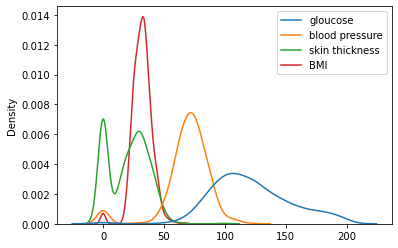

<AxesSubplot:ylabel='Density'>

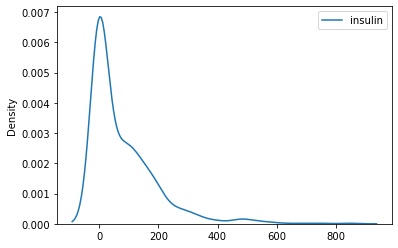

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(data = data[['gloucose','blood pressure','skin thickness','BMI']])
plt.show()
sns.kdeplot(data = data[['insulin']])

### 결측치 대체하기

In [44]:
col = ['gloucose', 'blood pressure','skin thickness','insulin','BMI']

def imput_mean(df, col):
    df.loc[(df[col] == 0), col] = df.loc[df[col] != 0, col ].mean()

In [45]:
for i in col:
    imput_mean(X_train, i)


/anaconda/envs/py38_tensorflow/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/anaconda/envs/py38_tensorflow/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/anaconda/envs/py38_tensorflow/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of

<AxesSubplot:ylabel='Density'>

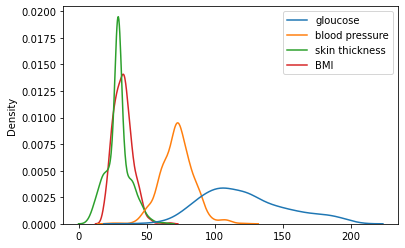

In [46]:
sns.kdeplot(data = X_train[['gloucose','blood pressure','skin thickness','BMI']])

In [47]:
# 5. Keras 패키지 가져오기
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation

In [13]:
# 6. MLP 모델 생성
model = keras.Sequential()

In [48]:
# network 생성
model.add(Dense(input_dim = 8, units = 64, activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [49]:
# 7. Compile - Optimizer, Loss function 설정
#adam = keras.optimizers.Adam(lr = 0.1)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam',
             metrics = ['accuracy'])

In [53]:
# 8. 모델 생성 
model1 = keras.Sequential()

model1.add(Dense(input_dim = X_train.shape[1], units = 64, activation = 'relu'))
model1.add(Dense(units = 128, activation = 'relu'))
model1.add(Dense(units = 64, activation = 'relu'))
model1.add(Dense(units = 1, activation = 'sigmoid'))

model1.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 64)                576       
_________________________________________________________________
dense_30 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_31 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_32 (Dense)             (None, 1)                 65        
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
_________________________________________________________________


In [54]:
# 모델 compile
model1.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
               metrics = ['accuracy'])

In [55]:
# 모델 학습하기
batch_size = 16
epochs = 100

# model1.fit(X_train, y_train,
#            batch_size = batch_size,
#            epochs = epochs,
#            verbose = 1)


model1.fit(X_train, y_train,
         batch_size = batch_size,
         epochs = epochs,
         verbose = 0)

In [58]:
# 모델 평가하기
print('전처리 전_test:',model.evaluate(X_test, y_test))
print('전처리 후_test:',model1.evaluate(X_test, y_test))

3/3 [==============================] - 0s 2ms/step - loss: 0.6503 - accuracy: 0.6494
전처리 전_test: [0.6503174304962158, 0.649350643157959]
3/3 [==============================] - 0s 3ms/step - loss: 1.8378 - accuracy: 0.6753
전처리 후_test: [1.8378371000289917, 0.6753246784210205]


In [59]:
print(X_train.shape[0]/batch_size)

38.375


In [60]:
# 4. Train set, Test set 나누기
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1234)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = 1234)

print('X:', X_train.shape, X_val.shape, X_test.shape)
print('y:', y_train.shape, y_val.shape, y_test.shape)


X: (614, 8) (77, 8) (77, 8)
y: (614,) (77,) (77,)


In [61]:
model = keras.Sequential()

model.add(Dense(input_dim = X_train.shape[1], units = 64, activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 1, activation = 'sigmoid'))

In [62]:
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
               metrics = ['accuracy'])

In [63]:
# 모델 학습하기
batch_size = 16
epochs = 100


hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 batch_size = batch_size,
                 epochs = epochs,
                 verbose = 0)

In [64]:
#  모델 평가하기
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.7525 - accuracy: 0.7403


[0.7524868249893188, 0.7402597665786743]

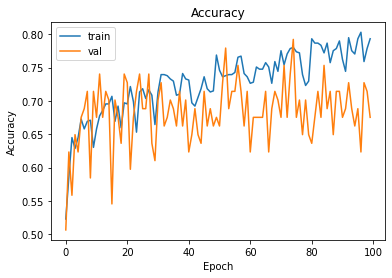

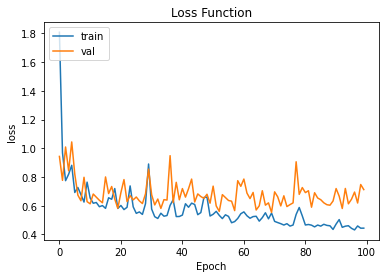

In [65]:
# 학습 시각화
import matplotlib.pyplot as plt

# 정확도 그래프
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc = 'upper left')
plt.title('Accuracy')
plt.show()

# loss 그래프
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc = 'upper left')
plt.title('Loss Function')
plt.show()

Data의 차이가 크고 학습을 할 때마다 weight값이 차이가 나는 것을 알 수 있다.  


#### Loss function  
20번 epoch 이후부터는 overfitting이 일어나고 있다  

### 1. Drop Out : Overfitting 해결법

In [66]:
from tensorflow.keras.layers import Dropout

model = keras.Sequential()

model.add(Dense(input_dim = X_train.shape[1], units = 128, activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))

model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
               metrics = ['accuracy'])

In [67]:
batch_size = 16
epochs = 100
hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 batch_size = batch_size,
                 epochs = epochs,
                 verbose = 0)

In [68]:
# 8. 모델 평가하기
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 0.6711 - accuracy: 0.7013


[0.6711458563804626, 0.701298713684082]

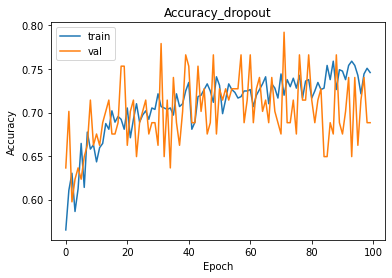

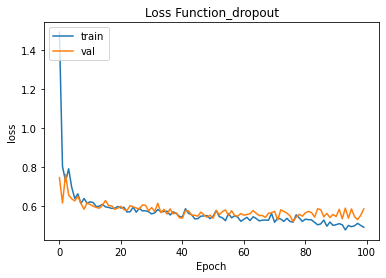

In [69]:
# 정확도 그래프
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc = 'upper left')
plt.title('Accuracy_dropout')
plt.show()

# loss 그래프
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc = 'upper left')
plt.title('Loss Function_dropout')
plt.show()

In [70]:
from keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Dropout

model = keras.Sequential()

model.add(Dense(input_dim = X_train.shape[1], units = 128, activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))

model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
               metrics = ['accuracy'])

batch_size = 16
epochs = 1000

# 빠른 종료
early_stopping = EarlyStopping(monitor = 'val_loss', # 이전 val_loss보다 높아지면 중지
                              patience = 10) # epochs 10까지는 지켜보도록 함

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 batch_size = batch_size,
                 epochs = epochs,
                 verbose = 0,
                 callbacks = [early_stopping])

In [71]:
# 모델 평가하기
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 0.5854 - accuracy: 0.7273


[0.5853900909423828, 0.7272727489471436]

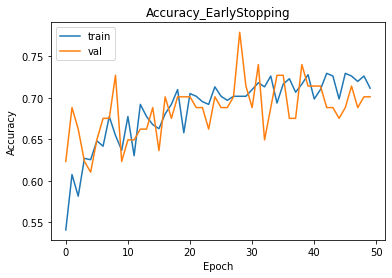

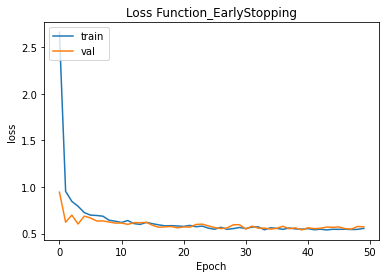

In [72]:
# 정확도 그래프
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc = 'upper left')
plt.title('Accuracy_EarlyStopping')
plt.show()

# loss 그래프
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc = 'upper left')
plt.title('Loss Function_EarlyStopping')
plt.show()

### 2. Overfitting 해결 :Regularization

In [73]:
model.add(Dense(64, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(128, activation = 'relu',
               kernel_regularizer = keras.regularizers.L2(0.1)))

# model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [74]:
from keras.callbacks import EarlyStopping

from tensorflow.keras.layers import Dropout

model = keras.Sequential()

model.add(Dense(64, input_dim = X_train.shape[1], activation = 'relu'))
model.add(Dense(128, activation = 'relu',
               kernel_regularizer = keras.regularizers.L2(0.1)))

# model.add(Dropout(0.2))

model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

#compile 
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
               metrics = ['accuracy'])
# modeling
batch_size = 16
epochs = 1000

# 빠른 종료
early_stopping = EarlyStopping(monitor = 'val_loss', # 이전 val_loss보다 높아지면 중지
                              patience = 10) # epochs 10까지는 지켜보도록 함

hist = model.fit(X_train, y_train,
                 validation_data = (X_val, y_val),
                 batch_size = batch_size,
                 epochs = epochs,
                 verbose = 0,
                 callbacks = [early_stopping])

In [75]:
# 모델 평가하기
model.evaluate(X_train, y_train)
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 2ms/step - loss: 0.5631 - accuracy: 0.7403


[0.5631431937217712, 0.7402597665786743]

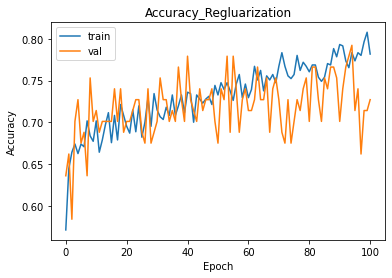

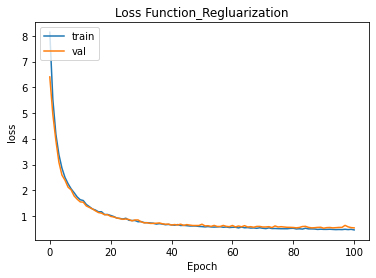

In [76]:
# 정확도 그래프
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'val'], loc = 'upper left')
plt.title('Accuracy_Regluarization')
plt.show()

# loss 그래프
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc = 'upper left')
plt.title('Loss Function_Regluarization')
plt.show()